In [1]:
#Luís Filipe Silva Forti - 14592348
#Miguel Rodrigues Fonseca - 14682196

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import pingouin as pg

In [3]:
#Abre o arquivo
df = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')

#Remove linhas com dados inúteis
df = df[df.User_Score != "tbd"] #valores indefinidos
df = df[df.Critic_Score != "tbd"] #valores indefinidos
df = df.dropna() #Valores inválidos

#Separa as colunas desejadas
df = df.filter(['Critic_Score', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)

# Dados Globais

In [64]:
#Confiança da amostra
confianca = 0.9

#Nomes e cores para os plots
nomes = ['NA', 'EU', 'JP', 'Resto']
cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

#Ordena por pontuação dos críticos
pontCriticos = df.sort_values("Critic_Score", ascending=True)
pontCriticos = pontCriticos.reset_index()

#Tabela com os valores de vendas de todas as regiões
valores = np.column_stack((pontCriticos.NA_Sales, pontCriticos.EU_Sales, pontCriticos.JP_Sales, pontCriticos.Other_Sales))
#Pega o número de linhas e colunas dos dados
n, m = valores.shape

#Pega as possíveis notas dos críticos
X = pontCriticos.Critic_Score.unique().tolist()
#Para fazer a regressão polinomial, o vetor de posições precisa ser feito de vetores
X2 = [[i] for i in pontCriticos.Critic_Score.unique()]

#Tabela com alguns dos dados, para apresentar o que será utilizado
print(tabulate(pontCriticos.iloc[::300, 1:], headers='keys', tablefmt='psql'))

+------+----------------+------------+------------+------------+---------------+
|      |   Critic_Score |   NA_Sales |   EU_Sales |   JP_Sales |   Other_Sales |
|------+----------------+------------+------------+------------+---------------|
|    0 |             13 |       0.02 |       0.01 |       0    |          0.01 |
|  300 |             43 |       0.05 |       0    |       0    |          0    |
|  600 |             49 |       0.15 |       0    |       0    |          0.01 |
|  900 |             54 |       0.19 |       0.22 |       0    |          0.09 |
| 1200 |             58 |       0.07 |       0.02 |       0    |          0.01 |
| 1500 |             60 |       0.13 |       0.12 |       0    |          0.02 |
| 1800 |             63 |       1.07 |       0.04 |       0.02 |          0.17 |
| 2100 |             65 |       0.52 |       0.75 |       0    |          0.16 |
| 2400 |             67 |       1.12 |       0.6  |       0.07 |          0.16 |
| 2700 |             69 |   

# Intervalo de confiança

In [5]:
#Para salvar as médias e limites de vendas em cada região
medias = np.zeros(m)
limites = np.zeros(shape=(m, 2))
#Para salvar as faixas dos intervalos
faixas = np.zeros(m)

#Para cada região
for i in range(0, m):
    #Pega as vendas
    amostra = valores[:, i]
    
    #Média
    medias[i] = np.mean(amostra)
    #Limites
    limites[i, 0] = medias[i] - stats.norm.ppf(1 - (1 - confianca)/2) * np.std(amostra, ddof=1) / (amostra.size**(1/2))
    limites[i, 1] = medias[i] + stats.norm.ppf(1 - (1 - confianca)/2) * np.std(amostra, ddof=1) / (amostra.size**(1/2))
    #Faixa
    faixas[i] = stats.norm.ppf(1 - (1 - confianca)/2) * np.std(amostra, ddof=1) / (amostra.size**(1/2)) * 2

#Imprime os dados coletados
dados = np.column_stack((nomes, medias, limites, faixas, [confianca] * m))
print(tabulate(dados, headers=['Região', 'Média', 'Limites inferiores', 'Limites superiores', 'Faixa do intervalo', 'Confiança'], tablefmt="grid"))

+----------+-----------+----------------------+----------------------+----------------------+-------------+
| Região   |     Média |   Limites inferiores |   Limites superiores |   Faixa do intervalo |   Confiança |
+==========+===========+======================+======================+======================+=============+
| NA       | 0.394484  |            0.375223  |            0.413744  |            0.0385217 |         0.9 |
+----------+-----------+----------------------+----------------------+----------------------+-------------+
| EU       | 0.236089  |            0.222404  |            0.249774  |            0.0273698 |         0.9 |
+----------+-----------+----------------------+----------------------+----------------------+-------------+
| JP       | 0.0641582 |            0.0584327 |            0.0698838 |            0.0114511 |         0.9 |
+----------+-----------+----------------------+----------------------+----------------------+-------------+
| Resto    | 0.0826769 |    

# Regressão polinomial

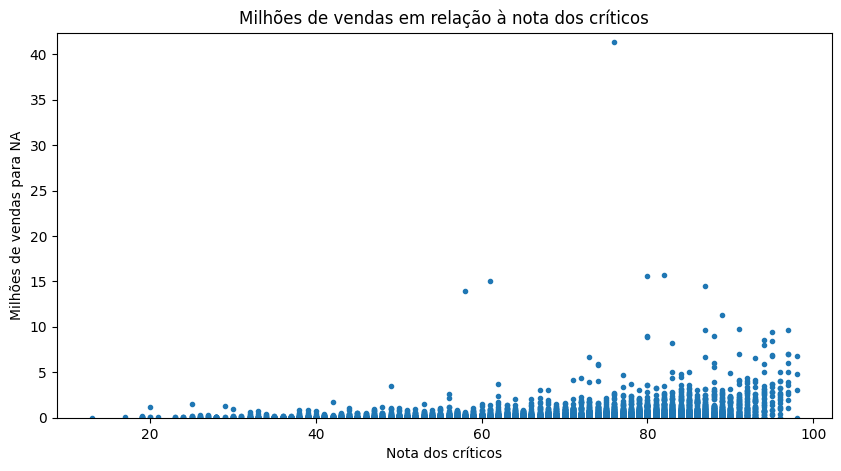

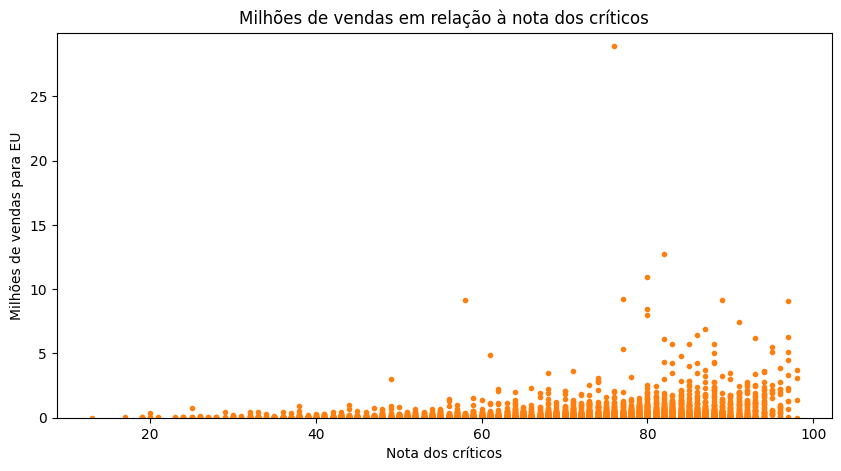

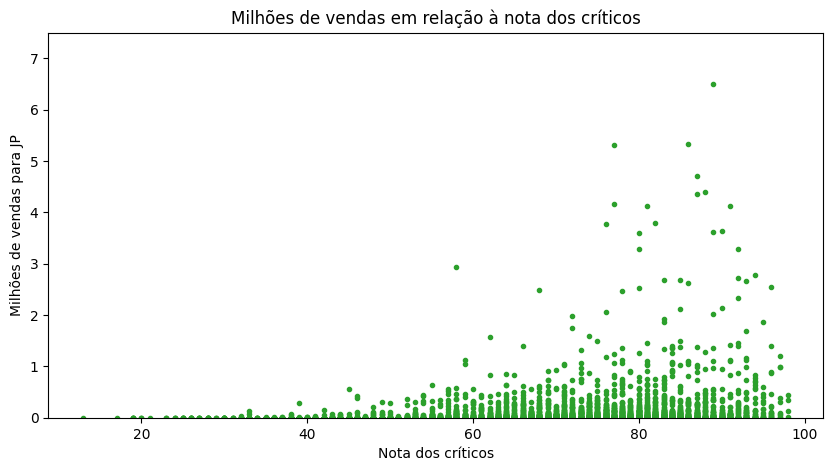

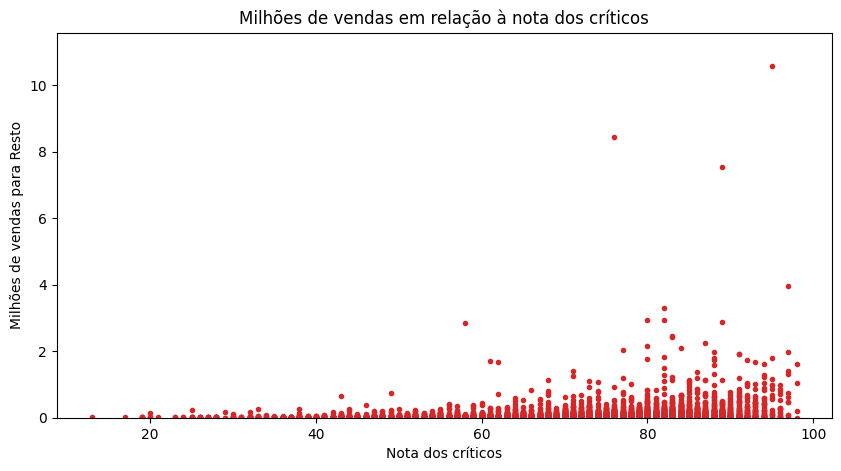

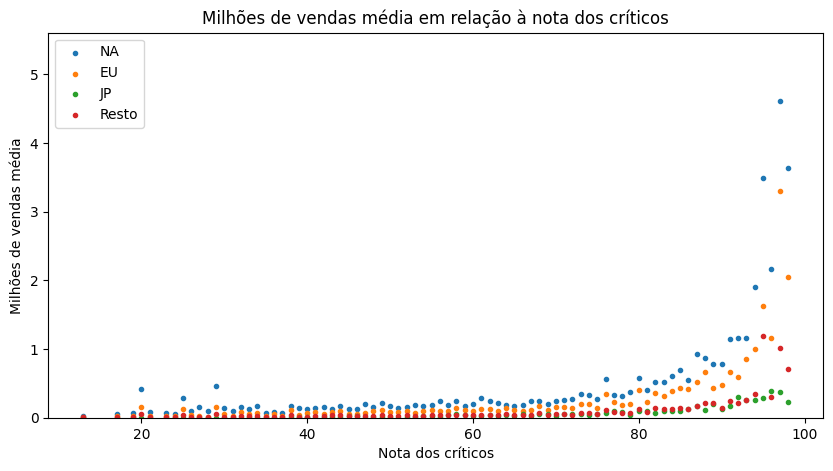

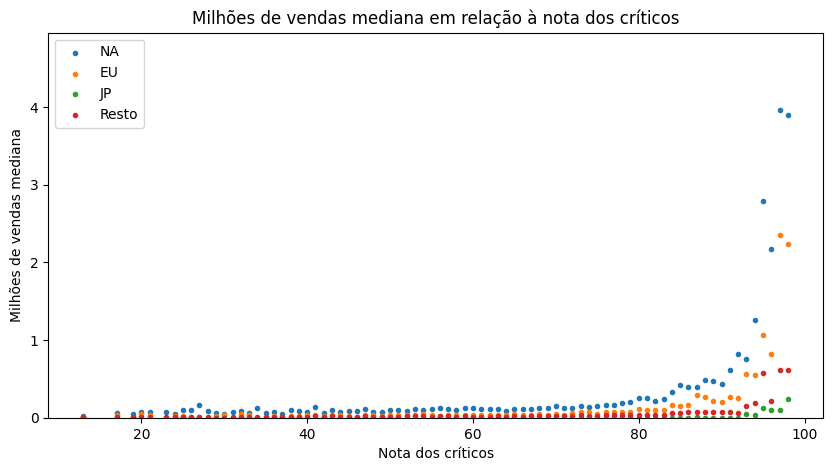

In [29]:
#Para calcular as médias e medianas de cada avaliação
medias = np.zeros(shape=(len(X), m))
medianas = np.zeros(shape=(len(X), m))

#Para cada pontuação
for i in range(0, len(X)):
    #Pega as vendas relacionadas à nota para todas as regiões
    val = valores[pontCriticos.Critic_Score == X[i]]
    
    #Calcula as médias e medianas por região
    medias[i, :] = np.mean(val, axis=0)
    medianas[i, :] = np.median(val, axis=0)

#Plota os dados coletados para cada região
for i in range(0, m):
    plt.figure(figsize=(10, 5))
    plt.scatter(pontCriticos.Critic_Score, valores[:, i], marker='.', c=cores[i])
    plt.title('Milhões de vendas em relação à nota dos críticos')
    plt.xlabel('Nota dos críticos')
    plt.ylabel('Milhões de vendas para ' + nomes[i])
    plt.ylim(0.0, np.max(valores[:, i]) + 1)
    plt.show()

#Plota as médias para cada região no mesmo gráfico
plt.figure(figsize=(10, 5))

for i in range(0, m):
    plt.scatter(X, medias[:, i], marker='.', c=cores[i])
    
plt.title('Milhões de vendas média em relação à nota dos críticos')
plt.xlabel('Nota dos críticos')
plt.ylabel('Milhões de vendas média')
plt.ylim(0.0, np.max(medias) + 1)
plt.legend(nomes)
plt.show()

#Plota as medianas para cada região no memso gráfico
plt.figure(figsize=(10, 5))
for i in range(0, m):
    plt.scatter(X, medianas[:, i], marker='.', c=cores[i])
plt.title('Milhões de vendas mediana em relação à nota dos críticos')
plt.xlabel('Nota dos críticos')
plt.ylabel('Milhões de vendas mediana')
plt.ylim(0.0, np.max(medianas) + 1)
plt.legend(nomes)
plt.show()

In [58]:
#Intervalo de Ns que devem serem calculados
ns = [val for val in range(1, 151)]

#N e erro do menor erro para cada região
nErr = [[-1, 100]] * m

#Para cada valor de n
for i in ns:
    for j in range(0, m):
        #Configura a função pra usar o grau n
        pr = PolynomialFeatures(degree = i)
        #Configura para os valores de X passados
        X_poly = pr.fit_transform(X2)
        #Prepara a função
        lr_2 = LinearRegression()
        #Passa os valores
        lr_2.fit(X_poly, medias[:, j])

        err = sklearn.metrics.mean_squared_error(medias[:, j], lr_2.predict(X_poly))
        if nErr[j][1] - err > 10**-4:
            nErr[j][1] = err
            nErr[j][0] = i

#Cria uma matriz com os dados
melhoresPrecisoes = np.column_stack((nomes, nErr))
#Imprime a tabela sobre as precisões
print(tabulate(melhoresPrecisoes, headers=['Região', 'Grau do polinômio relacionado', 'Menor erro quadrático médio'], tablefmt="grid"))

+----------+---------------------------------+-------------------------------+
| Região   |   Grau do polinômio relacionado |   Menor erro quadrático médio |
+==========+=================================+===============================+
| NA       |                              10 |                   0.000493156 |
+----------+---------------------------------+-------------------------------+
| EU       |                              10 |                   0.000493156 |
+----------+---------------------------------+-------------------------------+
| JP       |                              10 |                   0.000493156 |
+----------+---------------------------------+-------------------------------+
| Resto    |                              10 |                   0.000493156 |
+----------+---------------------------------+-------------------------------+


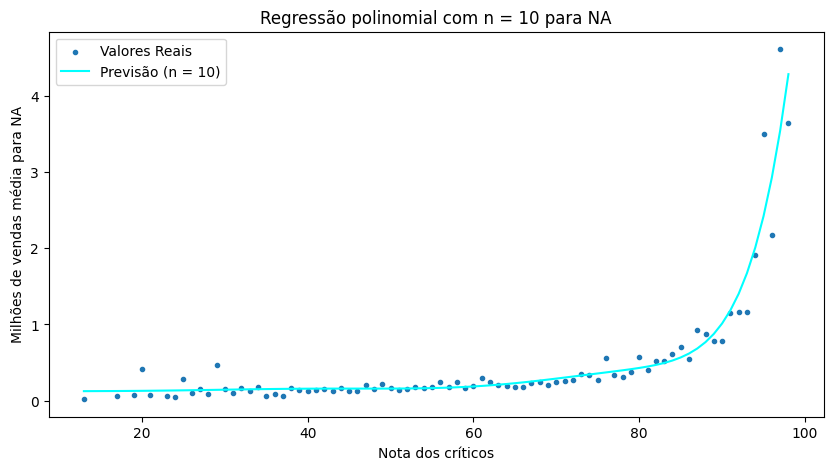

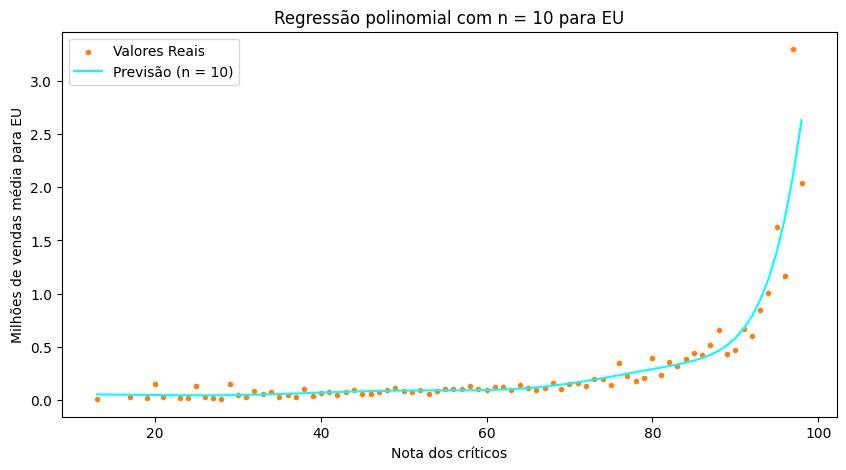

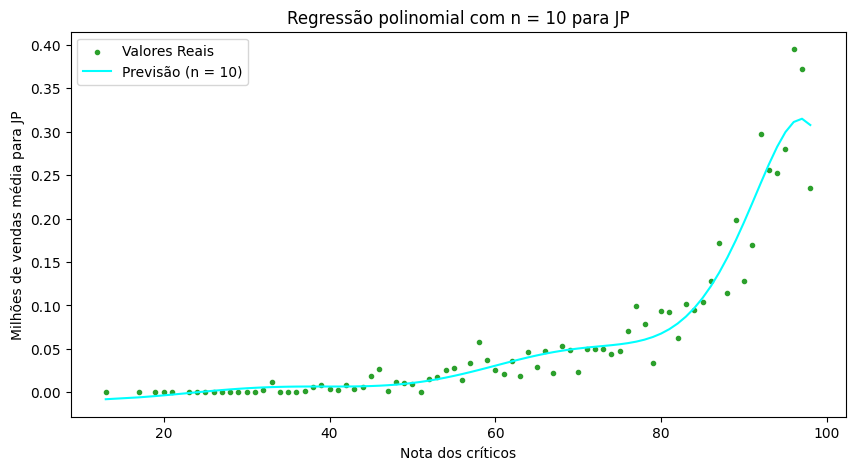

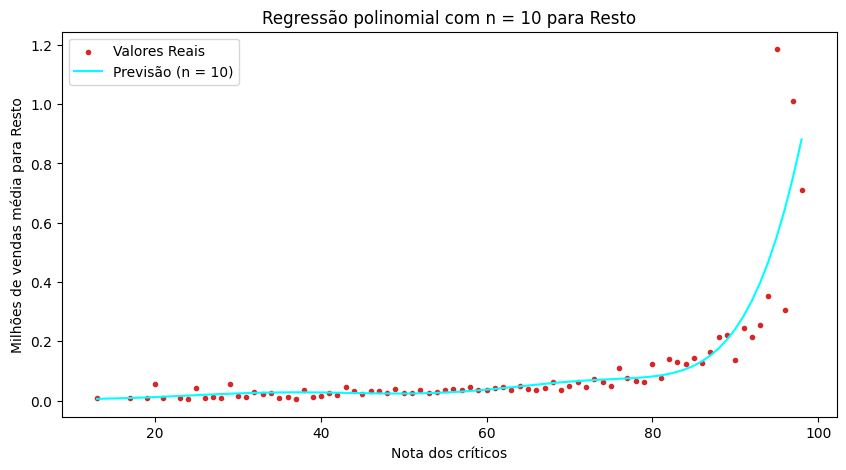

In [51]:
#Valor de n mais preciso dos testes
ns = 10

#Para cada região
for i in range(0, len(nomes)):
    #Configura o polinômio para a região com grau definido anteriormente
    pr = PolynomialFeatures(degree = ns)
    X_poly = pr.fit_transform(X2)
    lr_2 = LinearRegression()
    lr_2.fit(X_poly, medias[:, i])

    #Imprime o gráfico com os valores reais e previstos para a região
    plt.figure(figsize=(10, 5))
    plt.scatter(X, medias[:, i], marker='.', c=cores[i])
    plt.plot(X, lr_2.predict(X_poly), color = 'cyan')
    plt.title('Regressão polinomial com n = ' + str(ns) + " para " + nomes[i])
    plt.xlabel('Nota dos críticos')
    plt.ylabel('Milhões de vendas média para ' + nomes[i])
    plt.legend(['Valores Reais', 'Previsão (n = ' + str(ns) + ')'], loc='best', facecolor='white')
    plt.show()

# Anova

In [59]:
#Para os testes do ANOVA, foi necessário adaptar o dataset utilizado
#Criou-se uma variação onde, ao invés de separar as vendas por região, elas foram incluídas às linhas
#Assim pode-se comparar as notas em função da regiõa
dadosAnova = pd.melt(df,
                  id_vars=['Critic_Score'],
                  value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
                  var_name='Regiao',
                  value_name='Vendas')

#Para facilitar a visualização por nota
dadosAnova = dadosAnova.sort_values("Critic_Score", ascending=True)

#Imprime os dados formatados
print()
print(dadosAnova)

#O teste ANOVA tem dois requerimentos: normalidade e homocedasticidade
#Normalidade: os dados são distribuídos de forma normal
#Homocedasticidade: as varianças de cada grupo são aproximadamente iguais

#Para a normalidade, foi feito o teste de D'Agostino-Pearson para cada região

#Cria uma matriz para os dados
resDAgostino = np.zeros((m, 2))

#Para cada região
for i in range(0, m):
    #Realiza o teste para os dados da região
    resDAgostino[i] = stats.normaltest(dadosAnova[dadosAnova.Regiao == dadosAnova.Regiao.unique()[i]]['Vendas'])

#Imprime os resultados obtidos
print("\nTeste D'Agostino-Pearson")
print(tabulate(resDAgostino, headers=['Resultado', 'Valor-p'], tablefmt="grid"))

#Para a homocedasticidade, foi utilizado o teste de Levene

#Aplica o teste
estatistica, valorP = stats.levene(valores[:, 0], valores[:, 1], valores[:, 2], valores[:, 3])

#Imprime os resultadps
resLevene = [[estatistica, valorP]]
print("\nTeste de Levene")
print(tabulate(resLevene, headers=['Resultado', 'Valor-p'], tablefmt="grid"))

#Os resultados obtidos pelo código acima afirma que nenhuma das distribuições é normal e que não há homocedasticidade
#Em relação a normalidade, a grande quantidade de dados do dataset permite que ainda se possa aplicar o ANOVA
#Sobre a heterocedasticidade, o teste ANOVA de Welch consegue contornar este problema, assim ele será utilizado para a análise

#Realiza-se o ANOVA de Welch sobre os dados
resANOVA = pg.welch_anova(dv = "Vendas", between="Regiao", data=dadosAnova)

#Imprime os resultados
print("\nTeste ANOVA de Welch")
print(tabulate([resANOVA.values[0][1:5]], 
               headers=['Grau de liberdade numerador (dentro)', "Graus de liberdade denominador (entre)", 'Valor-f', 'Valor-p'], tablefmt="grid"))


       Critic_Score       Regiao  Vendas
26705          13.0  Other_Sales    0.01
19880          13.0     JP_Sales    0.00
6230           13.0     NA_Sales    0.02
13055          13.0     EU_Sales    0.01
25794          17.0  Other_Sales    0.01
...             ...          ...     ...
23587          98.0  Other_Sales    0.00
20507          98.0  Other_Sales    1.03
9937           98.0     EU_Sales    0.00
20512          98.0  Other_Sales    1.61
6862           98.0     EU_Sales    3.69

[27300 rows x 3 columns]

Teste D'Agostino-Pearson
+-------------+-----------+
|   Resultado |   Valor-p |
+=============+===========+
|     14706   |         0 |
+-------------+-----------+
|     10962.3 |         0 |
+-------------+-----------+
|     13755   |         0 |
+-------------+-----------+
|     13718.1 |         0 |
+-------------+-----------+

Teste de Levene
+-------------+--------------+
|   Resultado |      Valor-p |
+=============+==============+
|     298.938 | 5.78051e-191 |
+-----

# Teste do Qui-Quadrado

In [71]:
#Resultados
res = np.zeros(m)
#Valores-p
p = np.zeros(m)
#Graus de liberdade
dof = np.zeros(m)

#Valores para verificar se o teste é válido
valoresVerificacao = np.zeros((m, 2))

#Para uma boa análise sober o teste do Qui-Quadrado, a tabela de contingência não pode ter nenhuma frequência menor que 1 e, no máximo, 20% entre 1 e 5
#Assim, os dados serão agrupados por pontuação e número de vendas

#Grupos de número de vendas
#Entre 0 e 0.1 milhões, é um jogo sem sucesso
#Entre 0.1 e 0.5 milhões, é umjogo bem-sucedido
#Acima de 0.5 milhões, é um jogo muito bem-sucedido
valoresComp = [0, 0.1, 0.5, 10**5]

#Grupos de avaliações
#A maioria dos jogos do banco de dados está nas maiores pontuações
#Assim, os grupos de avaliações estão dispersos de forma geométrica invetida, onde a maior densidade está nos valores maiores
#Isso é feito ao subtrair de um valor de referência uma progressão geométrica que inicia no máximo e termina no mínimio
avaliacoes = (np.max(pontCriticos.Critic_Score) + np.min(pontCriticos.Critic_Score) - 
              np.geomspace(np.max(pontCriticos.Critic_Score.unique()), np.min(pontCriticos.Critic_Score.unique()), 10))

#Para cada região
for i in range(0, m):
    #A tabela de contingência da região
    tabCont = np.zeros((avaliacoes.size - 1, len(valoresComp) - 1))

    #Para cada grupo de avaliações
    for j in range(0, avaliacoes.size - 1):
        #Para cada grupo de número de vendas
        for k in range(0, len(valoresComp) - 1):
            #Para cada posição da tabela de contingência
            #Verifica quais valores estão no grupo atual das avaliações e quais estão no grupo atual do número de vendas
            #Ao multiplicar os resultados, ele irá analisar apenas aqueles que todas as comaparações deram True
            #Por fim, salva a quantidade de casos que estão contidos em ambos os grupos
            tabCont[j, k] = valores[((pontCriticos.Critic_Score >= avaliacoes[j]) * (pontCriticos.Critic_Score < avaliacoes[j+1])
                                     * (valores[:, i] >= valoresComp[k]) * (valores[:, i] < valoresComp[k+1])), i].size

    #Calcula o qui-quadrado para a região
    res[i], p[i], dof[i], expected = stats.chi2_contingency(tabCont)

    #Salva os valores para verificação
    valoresVerificacao[i, 0] = expected[expected[:] < 1].size
    valoresVerificacao[i, 1] = expected[(expected[:] >= 1) * (expected[:] < 5)].size / expected.size
    
#Imprime os dados de verificação
melhoresPrecisoes = np.column_stack((nomes, valoresVerificacao))
print(tabulate(melhoresPrecisoes, headers=['Região', 'Quantidade de valores < 1', 'Porcentagem de valores entre 1 e 5'], tablefmt="grid"))

print("\n\n")

#Cria uma matriz com os dados
melhoresPrecisoes = np.column_stack((nomes, res, dof, p))
#Imprime a tabela sobre as precisões
print(tabulate(melhoresPrecisoes, headers=['Região', 'Resultado do qui-quadrado', 'Graus de liberdade', 'Valor-p'], tablefmt="grid"))

+----------+-----------------------------+--------------------------------------+
| Região   |   Quantidade de valores < 1 |   Porcentagem de valores entre 1 e 5 |
+==========+=============================+======================================+
| NA       |                           0 |                            0         |
+----------+-----------------------------+--------------------------------------+
| EU       |                           0 |                            0.037037  |
+----------+-----------------------------+--------------------------------------+
| JP       |                           0 |                            0.111111  |
+----------+-----------------------------+--------------------------------------+
| Resto    |                           0 |                            0.0740741 |
+----------+-----------------------------+--------------------------------------+



+----------+-----------------------------+----------------------+--------------+
| Região   |  